In [1]:
from pathlib import Path
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, RobustScaler

from sklearn.metrics import mean_absolute_error
from sklearn.svm import SVR

from natsort import natsorted

In [2]:
def replace_nan(df):
    # get a list of all the columns containing NaN
    nan_cols = df[df.columns[df.isnull().any()]].columns
    nan_cols = nan_cols.drop('bikes')
    # compute and fill each NaN with the columns mean
    df[nan_cols] = df[nan_cols].fillna(value=df[nan_cols].mean())

    
def show_nans(df):
    print(np.unique(df['station']))
    print(df.shape[0] - df.dropna().shape[0])
#     print(df[df.columns[df.isnull().any()]].columns)
    print(df.isnull().any())
    print()
    

# converting weekdays into integers [1-7]
def convert_weekdays(df):
    df = df.replace(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
    [1, 2, 3, 4, 5, 6, 7])
    return df
    
def score_abs_error(model, data, num_docks, round_ = False):
    if round_ == True:
        y_pred = np.around(  model.predict(data.iloc[:,:-1].to_numpy()))# * num_docks  )
    else:
        y_pred = model.predict(data.iloc[:,:-1].to_numpy())# * num_docks
    y_gold = data["bikes"].to_numpy()# * num_docks
    
    return mean_absolute_error(y_gold, y_pred)

def reasonable_predictions(model, data):
    y_pred = model.predict(data.to_numpy())
    
    y_pred = np.around(y_pred)
    return y_pred


## This code is added

In [3]:
pd.options.mode.chained_assignment = None

def is_hol_weekend(row):
    if row['weekday'] == 6 or row['weekday'] == 7:
        return 1
    if row['isHoliday'] == 1:
        return 1
    if row['hour'] > 17 or row['hour'] < 9:
        return 1
    return 0

def generate_dataframe(dataframe):
    dataframe = convert_weekdays(dataframe)
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    # del df["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    default_columns = list(dataframe.columns)
    
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    default_columns = ["isOff"] + default_columns
    
    dataframe = dataframe[default_columns]
    
    print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
#     print(columns)
#     for c in columns:
#         dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    del dataframe["numDocks"]
    
    return dataframe, num_docks

def vectorise_dataframe(dataframe):
    
    # # deleting unneeded columns
    del dataframe["month"]
    del dataframe["year"]
    #del dataframe["timestamp"]
    del dataframe["station"]
    del dataframe["precipitation.l.m2"]
    #del dataframe["weekhour"]
    
    del dataframe["latitude"]
    del dataframe["longitude"]
    
    
    
    default_columns = list(dataframe.columns)
    #default_columns.remove('weekday')
    dataframe['isOff'] = dataframe.apply(is_hol_weekend,axis=1)
    
    #dataframe = pd.get_dummies(dataframe, columns=['weekday'])
    
    #default_columns = ["isOff", "weekday_Sunday", "weekday_Monday", "weekday_Tuesday", "weekday_Wednesday", 
                      #"weekday_Thursday", "weekday_Friday", "weekday_Saturday"] + default_columns
    
    default_columns = ["isOff"] + default_columns
    #del dataframe["weekday"]
    default_columns.remove('weekday')
    #print(default_columns)
    
    
    dataframe = dataframe[default_columns]
    
    #print(dataframe.columns)
    
    del dataframe['isHoliday']
    #del dataframe["timestamp"]
    
    
    columns = list(dataframe.columns[-6:])
    
    if "bikes" in columns:
        pass
    else:
        columns = columns[1:]
    
#     #print(columns)
#     for c in columns:
#         dataframe[c] = dataframe[c].to_numpy() / dataframe["numDocks"].to_numpy()
    num_docks = dataframe["numDocks"]
    
    dataframe["numDocks"]
    
    
    
    
#     columns_kept = ["weekday", "hour", "isOff",  'full_profile_3h_diff_bikes', 
#                      'short_profile_3h_diff_bikes',  "bikes"] #'bikes_3h_ago',
    
#     for c in dataframe.columns:
#         if c not in columns_kept:
#             del dataframe[c]
    
    
    return dataframe, num_docks

# Adding all files into one DataFrame
trains = []
vals = []

train_docks_list = []
val_docks_list = []

scalers = []



paths = []
for i, path in enumerate(Path('./Train/Train').rglob('*.csv')):
    paths.append(path)


paths = [Path(p) for p in natsorted([str(p) for p in paths ])]


for i, path in enumerate(paths):
    tmp = pd.read_csv(path)

    tmp = tmp.dropna(axis='rows')


    #if i  not in  val_inds:
    train, val = train_test_split(tmp, test_size=0.05)


    train, train_docks = vectorise_dataframe(train)
    val, val_docks = vectorise_dataframe(val)

    scaler = RobustScaler()

    train[train.columns[:-1]] = scaler.fit_transform(train[train.columns[:-1]])
    val[val.columns[:-1]] = scaler.transform(val[val.columns[:-1]])

    trains.append(train)
    vals.append(val)

    train_docks_list.append(train_docks)
    val_docks_list.append(val_docks)

    scalers.append(scaler)

    del tmp
#     elif i == val_inds[0]:
#         val_set = tmp.copy()


#         val_set, val_set_docks = vectorise_dataframe(val_set)
#     else:
#         print('found val set two')
#         val_set_two = tmp.copy()


#         val_set_two, val_set_docks_two = vectorise_dataframe(val_set_two)



In [4]:
# forest = RandomForestRegressor(n_estimators=500, n_jobs=6)
# print("initialised")
# forest.fit(train.iloc[:,:-1].to_numpy(), train["bikes"].to_numpy())

# importances = forest.feature_importances_
# imp_indixes = np.argsort(importances)[::-1]
# feature_order = train.columns[:-1][imp_indixes]
# importances = importances[imp_indixes]

# imp_df = pd.DataFrame(data = importances, index = feature_order, columns=["relative_importance"])

# print(score_abs_error(forest, val, val_docks))

# print(imp_df)
trains[0]

,isOff,numDocks,timestamp,day,hour,weekhour,windMaxSpeed.m.s,windMeanSpeed.m.s,windDirection.grades,temperature.C,relHumidity.HR,airPressure.mb,bikes_3h_ago,full_profile_3h_diff_bikes,full_profile_bikes,short_profile_3h_diff_bikes,short_profile_bikes,bikes
504,0.0,0.0,0.155709,0.166667,-1.043478,-0.465753,-0.292035,-0.666667,0.000000,0.988506,-1.192308,0.400000,0.0,0.923077,0.153846,0.923077,0.153846,6.0
382,0.0,0.0,-0.266436,-0.333333,0.869565,0.164384,1.415929,2.020833,0.000000,1.034483,-0.692308,-0.400000,1.0,-0.692308,-0.115385,-0.692308,-0.115385,3.0
736,-1.0,0.0,0.958478,0.916667,0.260870,0.397260,0.283186,0.333333,2.802491,0.275862,0.153846,0.455814,0.6,-1.384615,-0.576923,-1.384615,-0.576923,2.0
335,0.0,0.0,-0.429066,-0.500000,0.956522,-0.479452,-0.716814,-0.666667,-1.601423,-0.367816,-0.192308,-0.827907,-0.4,1.384615,0.923077,1.384615,0.923077,3.0
522,0.0,0.0,0.217993,0.166667,0.521739,-0.219178,0.424779,0.333333,-3.202847,0.206897,-0.423077,0.502326,-0.2,0.615385,0.384615,0.615385,0.384615,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
710,-1.0,0.0,0.868512,0.833333,0.086957,0.041096,-0.433628,-0.333333,-0.400356,0.183908,0.076923,0.427907,0.6,0.346154,1.557692,0.346154,1.557692,2.0
549,0.0,0.0,0.311419,0.250000,0.782609,0.150685,-0.433628,-0.333333,-0.400356,0.000000,-0.307692,0.027907,0.0,-0.461538,-0.076923,-0.461538,-0.076923,1.0
588,-1.0,0.0,0.446367,0.416667,0.000000,0.684932,-0.716814,-0.666667,1.201068,1.103448,-1.192308,0.297674,0.0,0.153846,-0.384615,0.153846,-0.384615,1.0
212,0.0,0.0,-0.854671,-0.916667,0.695652,0.136986,0.849558,1.000000,2.402135,0.873563,-0.038462,-0.827907,0.6,0.923077,0.230769,0.923077,0.230769,8.0


# Random elimination parameter tuning
## Random forest regressor

This cell uses `HalvingRandomSearchCV` to find near-optimal parameters for a random forest regressor. It takes a while to run with these parameters.

In [5]:
from time import time
from tqdm import tqdm
start = time()
print("initialised")

models = []

for i in tqdm(range(len(trains))):
    #forest_boost = AdaBoostRegressor(n_estimators=400, random_state=0, learning_rate = 0.5)
    forest_boost = RandomForestRegressor(n_estimators= 400, max_depth= 9)
    #forest_boost = GradientBoostingRegressor(n_estimators= 300, max_depth= 3, learning_rate= 0.07, loss="squared_error")#
    forest_boost.fit(trains[i].iloc[:,:-1].to_numpy(), trains[i]["bikes"].to_numpy())
    
    models.append(forest_boost)
print(f'fitted in {time() - start}s')

initialised


100%|████████████████████████████████████████████| 75/75 [00:48<00:00,  1.55it/s]

fitted in 48.422126054763794s


100%|████████████████████████████████████████████| 75/75 [00:02<00:00, 32.60it/s]

Non-rounded ensemble error: 1.8097245313713264
Rounded ensemble error: 1.7963218390804596


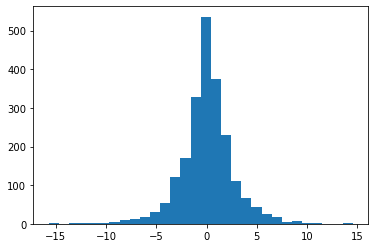

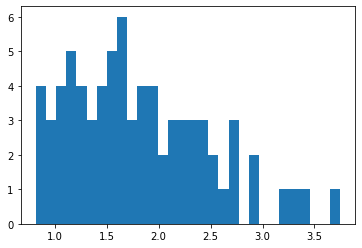

In [6]:
import matplotlib.pyplot as plt

errors = []
rounded_errors = []
y_pred = []
y_gold = []

for i in tqdm(range(len(vals))):
    errors.append(score_abs_error(models[i], vals[i], val_docks_list[i]))
    rounded_errors.append(score_abs_error(models[i], vals[i], val_docks_list[i], round_ = True))
    
    pred = list(models[i].predict(vals[i].iloc[:, :-1].to_numpy()))# * val_docks_list[i])
    
    y_pred = y_pred + pred
    
    y_gold = y_gold + list(vals[i]["bikes"])# * val_docks_list[i])
    
print(f'Non-rounded ensemble error: {np.mean(errors)}')
print(f'Rounded ensemble error: {np.mean(rounded_errors)}')

plt.hist(np.array(y_pred) - np.array(y_gold), bins=30)
plt.show()
plt.hist(errors, bins=30)
plt.show()

(n_estimators= 100, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.025, loss="absolute_error") = 6.171106155700234

## Score tracking

 -  vectorized data, n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error", score 2.31, rounding integers 2.29
 
 - un-vectorized data, n_estimators= 10000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, verbose = 1, loss="absolute_error", score 2.33, rounding integers 2.31
 
 - vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, 2.43, 2.42
 
 - un-vectorized data, n_estimators= 1000, min_samples_leaf= 5, max_depth= 5, learning_rate= 0.005, , loss="absolute_error",  2.4, 2.38

In [7]:


# results = pd.DataFrame(search.cv_results_)
# results["params_str"] = results.params.apply(str)
# params = search.param_distributions
# # results.drop_duplicates(subset=("params_str", "iter"), inplace=True)
# learning_rates = params["learning_rate"]
# mean_scores = results.pivot(
#     index="iter", columns="params_str", values="mean_test_score"
# )

# fig, ax = plt.subplots(figsize=(16,12))
# mean_scores.plot(legend=False, alpha=0.6, ax = ax, linewidth=8)

# labels = [
#     f"iter={i}\nn_samples={search.n_resources_[i]} \nn_candidates={search.n_candidates_[i]}"# \nn_estimators={params["n_estimators"][i]} "
#     for i in range(search.n_iterations_)
# ]

# ax.set_xticks(range(search.n_iterations_))
# ax.set_xticklabels(labels, rotation=45, multialignment="left")
# ax.set_title("Scores of candidates over iterations")
# ax.set_ylabel("mean test score", fontsize=15)
# ax.set_xlabel("iterations", fontsize=15)
# plt.tight_layout()
# plt.show()


In [8]:

# n_est = 10000

# import matplotlib.pyplot as plt
# test_score = np.zeros((n_est,), dtype=np.float64)

# y_test = val["bikes"]
# #y_pred = reasonable_predictions(forest_boost, val.iloc[:, :-1])

# for i, y_pred in enumerate(forest_boost.staged_predict(val.iloc[:,:-1])):
#     test_score[i] = forest_boost.loss_(y_test, y_pred)


# fig = plt.figure(figsize=(12
#                           , 12))
# plt.subplot(1, 1, 1)
# plt.title("Training and validation error")
# plt.plot(
#     np.arange(n_est) + 1,
#     forest_boost.train_score_,
#     "b-",
#     label="Training Set",
# )
# plt.plot(
#     np.arange(n_est) + 1, test_score, "r-", label="Validation Set"
# )
# plt.legend(loc="upper right")
# plt.xlabel("Boosting Iterations")
# plt.ylabel("Absolute error")
# #plt.yscale('log')
# fig.tight_layout()
# plt.show()

In [9]:
# plt.figure(figsize=(8,8))
# plt.hist(y_test*val_docks - forest_boost.predict(val.iloc[:,:-1])*val_docks, bins = 30)
# plt.show()

[201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236
 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254
 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272
 273 274 275]
208
230
233
249
2250
    bikes
Id       
1       3
2       6
3       8
4       4
5       6
0


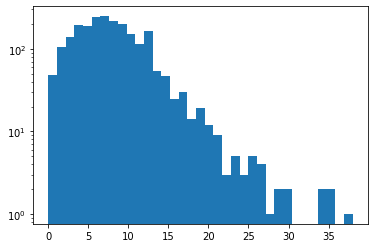

In [12]:
test = pd.read_csv('test.csv')

ids = test["Id"]

del test["Id"]
# del test["month"]
# del test["year"]

# convert_weekdays(test)
# # test[test.columns] = scaler.fit_transform(test[test.columns])

# for feature in lowest_ranked_10:
#     del test[feature]
    
# print(test.columns)  
# print(train.columns)

stations = np.unique(test["station"])
print(stations)
y_pred = []

for idx_station, station in enumerate(stations):
    

    test_i, test_docks_i = vectorise_dataframe(test[test["station"] == station])
    
    test_i = scalers[idx_station].transform(test_i)
    model = models[idx_station]
    
    y_pred_i = np.around(model.predict(test_i)).astype(np.int32).tolist()
    
    if np.max(np.unique(y_pred_i)) > 24:
        print(station)
    
    y_pred = y_pred + y_pred_i
    
    
    #y_pred = forest_boost.predict(test)
    #y_pred = np.around(ensemble_predict(models, scalers, model_weights, test)).astype(np.int32)


y_pred = np.array(y_pred)
#y_pred = np.where(y_pred < 0 , 0, y_pred)
    
print(len(y_pred))

sub_df = pd.DataFrame(data=y_pred, index = ids, columns = ["bikes"])

sub_df.index.name = 'Id'

print(sub_df.head())

sub_df.to_csv("submission.csv")

plt.hist(y_pred, bins=35)
plt.yscale('log')
print(np.min(y_pred))